## Polaris Planck map

In [9]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


On a map ~4 times larger than the Herschel field.

INFO: Auto-setting vmin to -1.152e-06 [aplpy.core]
INFO: Auto-setting vmax to  5.211e-05 [aplpy.core]


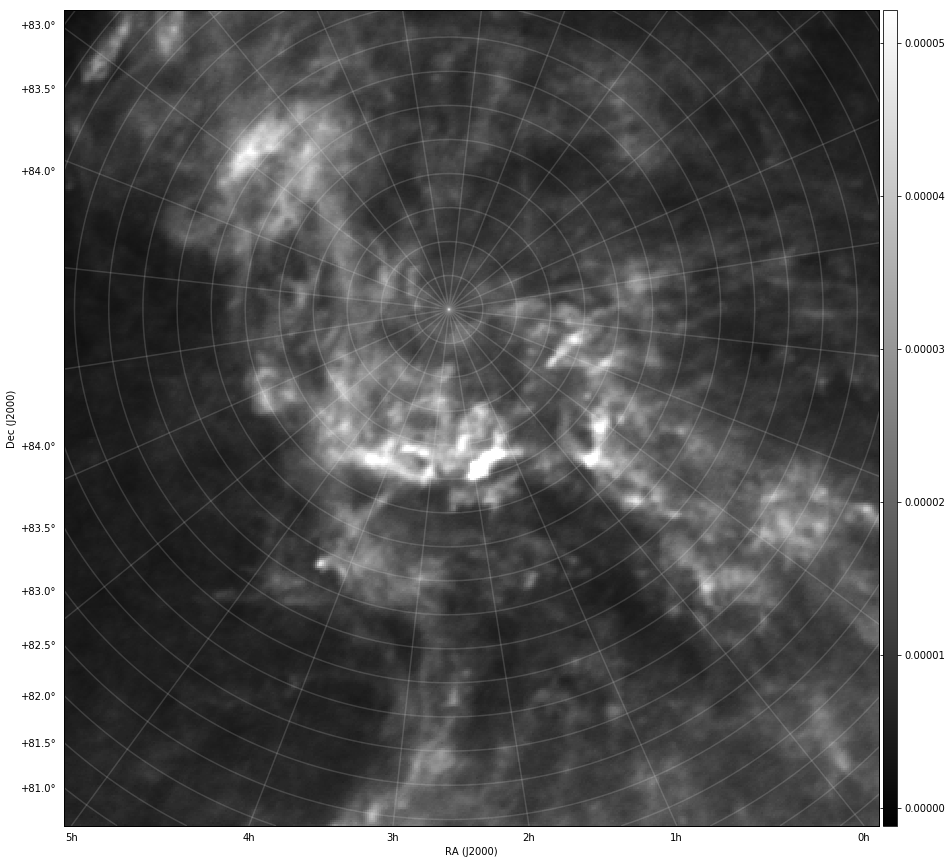

In [10]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Planck/HFI_tau353_polaris.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.25)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
#fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [93]:
HDU = fits.open(figfile)
im = HDU[0].data / 1.2e-26
hdP = HDU[0].header
reso = hdP['CDELT2'] * 60.
im -= np.mean(im)

HDU2 = fits.open('/Users/robitaij/postdoc/Herschel/Gould Belt/HGBS_polaris_cdens_rot_cut.fits')
hdH = HDU2[0].header

Wavenumbers sampled with wavelets on the Herschel map.

In [94]:
wav_k = np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wav_k_pola_hers.npy')
S1a = np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/S1a_pola_hers.npy')
wt = np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wt_pola_hers.npy')

In [104]:
from powspec import powspec
from wavan import fan_trans, apodize, padding
from astropy import wcs

[1.9999999999999996, 1.7999999999999994, 1.8999999999999995, 1.8999999999999995, 1.7999999999999994, 1.7999999999999994, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995]


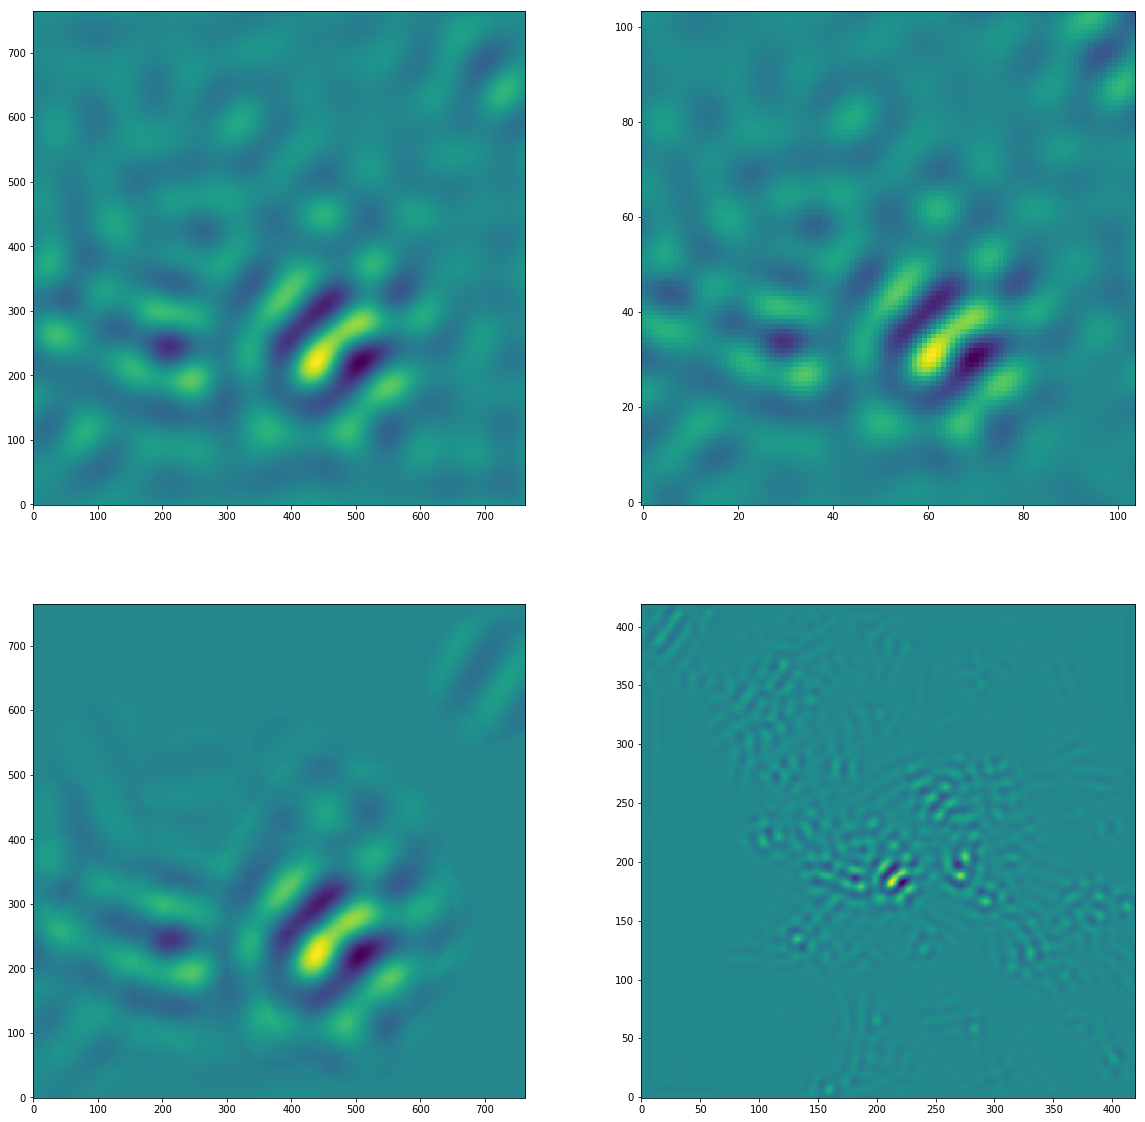

In [124]:
#q=[2.5]*9

#wtP, S11aP, wav_kP, S1aP, q = fan_trans(im, scales=wav_k[0:9], reso=reso, q=q, qdyn=True, skewl=0.4, apodize= 0.98, arrdim = np.array([512,512]))

MP = wav_kP.size
M = wav_k.size

wP = wcs.WCS(hdP,HDU)
wH = wcs.WCS(hdH,HDU2)

wx0H, wy0H = wH.all_pix2world(0,0,0)
x0P, y0P = wP.all_world2pix(wx0H, wy0H,0)

wx1H, wy1H = wH.all_pix2world(HDU2[0].data.shape[1]-1,HDU2[0].data.shape[0]-1,0)
x1P, y1P = wP.all_world2pix(wx1H, wy1H,0)

scale = 8

figure(figsize=(20,20))
subplot(2,2,1)
imshow(wt[scale,:,:].real,origin='below')

subplot(2,2,2)
#imshow(wtP[2*M+scale,:,:].real,origin='below')
imshow(wtP[scale,int(y0P):int(y1P),int(x0P):int(x1P)].real,origin='below')

subplot(2,2,3)
imshow(wt[M+scale,:,:].real,origin='below')

subplot(2,2,4)
#imshow(wtP[2*MP+scale,:,:].real,origin='below')
imshow(wtP[MP+scale,:,:].real,origin='below')

print q

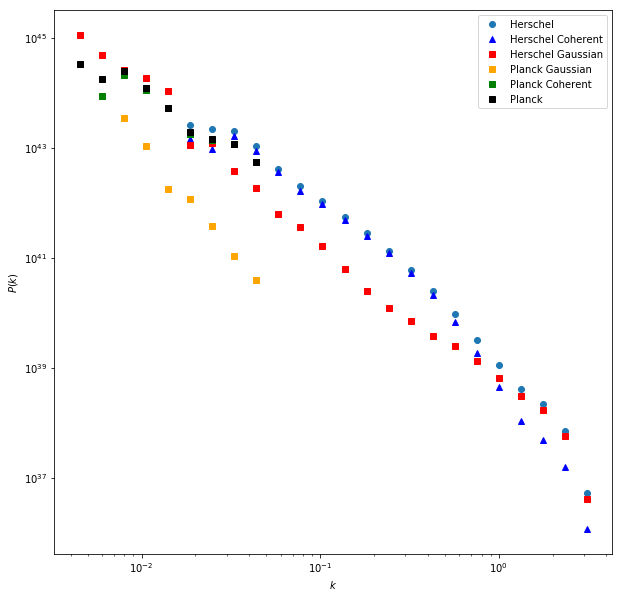

In [100]:
S1aPsub = np.mean(S11aP[0:MP,int(y0P):int(y1P),int(x0P):int(x1P)], axis=(1,2))
S1aCPsub = np.mean(S11aP[MP:2*MP,int(y0P):int(y1P),int(x0P):int(x1P)], axis=(1,2))
S1aGPsub = np.mean(S11aP[2*MP:3*MP,int(y0P):int(y1P),int(x0P):int(x1P)], axis=(1,2))

figure(figsize=(10,10))
plot(wav_k,S1a[0,:],'o',label='Herschel')
plot(wav_k,S1a[1,:],'^',color='blue',label='Herschel Coherent')
plot(wav_k,S1a[2,:],'s',color='red',label='Herschel Gaussian')
plot(wav_kP, S1aGPsub,'s',color='orange',label='Planck Gaussian')
plot(wav_kP, S1aCPsub,'s',color='green',label='Planck Coherent')
plot(wav_kP, S1aPsub,'s',color='black',label='Planck')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.legend()

Planck field regular Power Spectrum

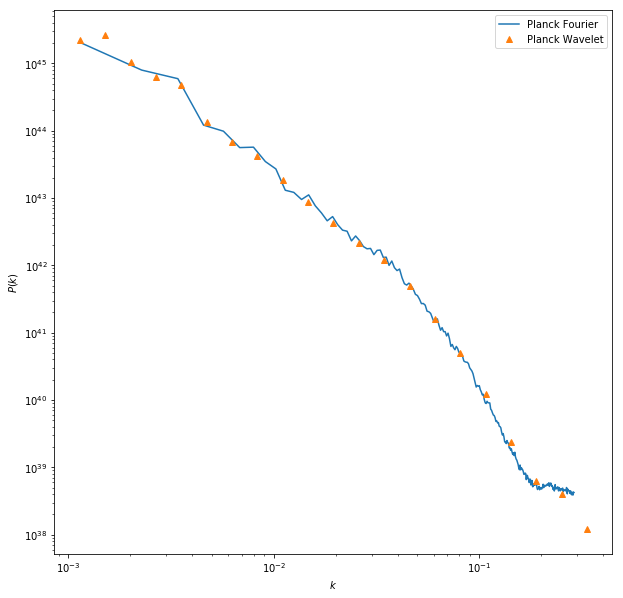

In [108]:
#Apodization

na = im.shape[1]
nb = im.shape[0]

tapper = apodize(nb,na,0.98)
imt = im *tapper
imr = padding(imt,512,512)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Wavelet power spectrum
#wtPo, S11aPo, wav_kPo, S1aPo, qo = fan_trans(im, reso=reso, q=0, qdyn=False, apodize= 0.98, arrdim = np.array([512,512]), cutpad=False)

figure(figsize=(10,10))
plot(tab_k, spec_k,label='Planck Fourier')
plot(wav_kPo, S1aPo,'^',label='Planck Wavelet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.legend()